# Importing the required libraries and packages

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from keras.datasets import cifar10

import cv2
import sys
import imageio

% matplotlib inline

Using TensorFlow backend.


# Loading Google Drive to save models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3) 

# Loading the data 

In [0]:
(train_feature, train_label), (test_feature, test_label) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_feature.shape
num_test, _, _, _ =  test_feature.shape
num_classes = len(np.unique(train_label))
print(num_test)

170500096/170498071 [==============================] - 10s 0us/step
10000


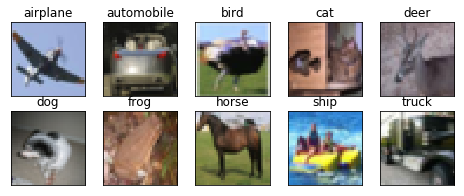

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_label[:]==i)[0]
    features_idx = train_feature[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)

plt.show()

# Part 1 of the assignment

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32, 32, 3))) #32,32; 3
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.125))
model.add(BatchNormalization())
model.add(Convolution2D(256, 3, 3, border_mode='same',)) #32,32; 5
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Convolution2D(64, 1, 1)) #32,32; 5
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #16,16; 10

model.add(Dropout(0.125))
model.add(BatchNormalization())
model.add(Convolution2D(256, 3, 3, border_mode='same')) #16,16; 12
model.add(Activation('relu'))

model.add(Dropout(0.125))
model.add(BatchNormalization())
model.add(Convolution2D(512, 3, 3, border_mode='same',)) #16,16; 14
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Convolution2D(64, 1, 1)) #16,16; 14
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #8,8; 28

model.add(Dropout(0.125))
model.add(BatchNormalization())
model.add(Convolution2D(256, 3, 3, border_mode='same')) #8,8; 30
model.add(Activation('relu'))

model.add(Dropout(0.125))
model.add(BatchNormalization())
model.add(Convolution2D(512, 3, 3, border_mode='same')) #8,8; 32
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Convolution2D(10, 1, 1)) #8,8; 32
model.add(Activation('relu'))

model.add(Convolution2D(10, 8, 8)) #1,1; 32

model.add(Flatten())
model.add(Activation('softmax'))

W0806 14:48:15.115906 139794489513856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
W0806 14:48:15.257458 139794489513856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 14:48:15.266988 139794489513856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 14:48:15.310916 139794489513856 deprecation_wrapper.py:119] From /usr/local/lib/python3.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       147712    
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 256)       0         
__________

In [0]:
train_features = train_feature.astype('float32')/255
test_features = test_feature.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_label, num_classes)
test_labels = np_utils.to_categorical(test_label, num_classes)

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0806 14:48:19.921765 139794489513856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
filepath="drive/My Drive/EVA/Assignment 9/saved_models/model.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callback_list = [lr_reducer, model_checkpoint]

### Model without CutOut

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, shuffle=False,
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, shuffle=False, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  
W0806 14:48:20.138544 139794489513856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be

Epoch 1/100
390/390 [==============================] - 94s 241ms/step - loss: 1.3819 - acc: 0.5047 - val_loss: 1.2668 - val_acc: 0.5891

Epoch 00001: val_acc improved from -inf to 0.58910, saving model to drive/My Drive/EVA/Assignment 9/saved_models/model.hdf5
Epoch 2/100
390/390 [==============================] - 90s 230ms/step - loss: 0.8907 - acc: 0.6836 - val_loss: 0.8554 - val_acc: 0.7077

Epoch 00002: val_acc improved from 0.58910 to 0.70770, saving model to drive/My Drive/EVA/Assignment 9/saved_models/model.hdf5
Epoch 3/100
390/390 [==============================] - 88s 227ms/step - loss: 0.7149 - acc: 0.7479 - val_loss: 0.8821 - val_acc: 0.7067

Epoch 00003: val_acc did not improve from 0.70770
Epoch 4/100
390/390 [==============================] - 88s 227ms/step - loss: 0.6014 - acc: 0.7906 - val_loss: 0.6911 - val_acc: 0.7699

Epoch 00004: val_acc improved from 0.70770 to 0.76990, saving model to drive/My Drive/EVA/Assignment 9/saved_models/model.hdf5
Epoch 5/100
390/390 [===

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
 model = load_model("drive/My Drive/EVA/Assignment 9/saved_models/model.hdf5")

W0807 00:35:42.744224 140098410600320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 00:35:42.791691 140098410600320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 00:35:42.853818 140098410600320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 00:35:42.854777 140098410600320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 00:35:42.857253 140098410

In [0]:
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 87.19


In [0]:
#Finding misclassified images
data = {'pred': model.predict_classes(test_features), 'true': np.argmax(test_labels,axis=1)} #axis=1!important!
output_df = pd.DataFrame(data=data)

# shows total mispredictions
misclassified_output = output_df[(output_df.pred != output_df.true)]
misclassified_output.shape

(1281, 2)

In [0]:
def getClassName(classNumber):
    for i in range(len(class_names)):
        if(classNumber == i):
            className = class_names[i]
    return className

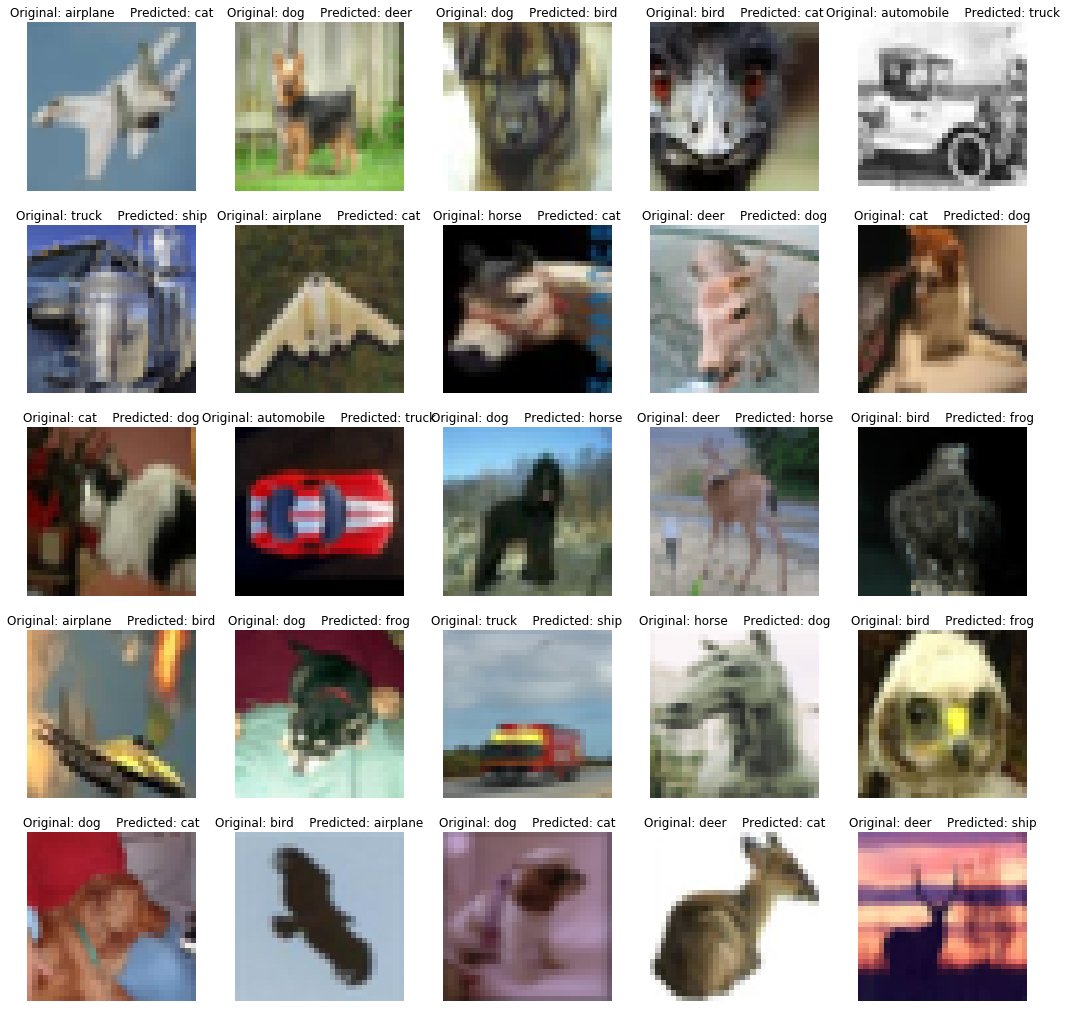

In [0]:
plt.figure(figsize = (18,18))

for i in range(25):
    plt.subplot(5, 5,i+1)
    img = test_features[misclassified_output.index[i]]
    img = img.reshape((32,32,3))
    plt.imshow(img, cmap='gray')
    plt.title("Original: " + getClassName(misclassified_output["true"].iloc[i])+"    Predicted: " + getClassName(misclassified_output["pred"].iloc[i]))
    plt.axis('off')
    
plt.show()

In [0]:
images = [10,57,125,211]

### Considering the layer: conv2d_8

In [0]:
#Function to plot original image and GradCAM image
def grad_cam_plot(image_number):
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    # Pixel normalization for test images
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    test_labels = np_utils.to_categorical(test_labels, num_classes)

    img = test_features[image_number]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    img = test_features[image_number]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.title("Original: " + getClassName(test_labels[image_number])+"    Predicted: " + getClassName(class_idx))
    plt.imshow(img)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
    cv2.waitKey(0)

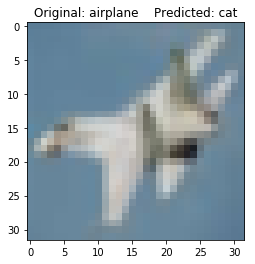

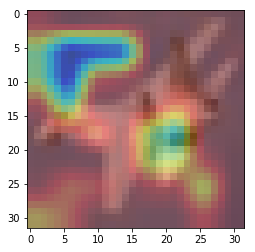

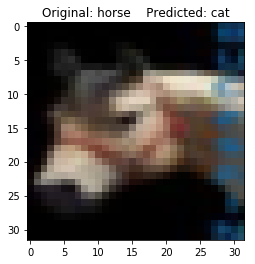

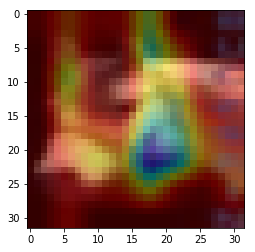

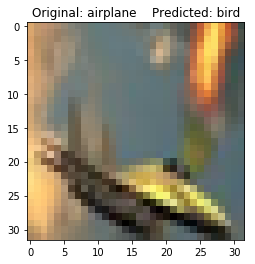

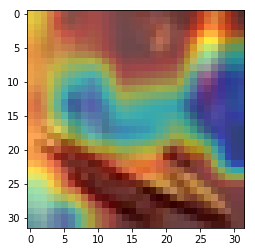

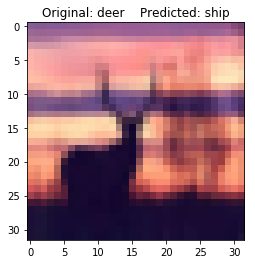

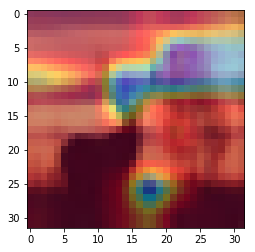

In [0]:
# Running a loop to plot original and GradCAM image for all the selected images
for i in range(len(images)):  
    grad_cam_plot(images[i])

### Considering the layer: activation_8

In [0]:
#Function to plot original image and GradCAM image
def grad_cam_plot(image_number):
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    # Pixel normalization for test images
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    test_labels = np_utils.to_categorical(test_labels, num_classes)

    img = test_features[image_number]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("activation_8")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    img = test_features[image_number]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.title("Original: " + getClassName(test_labels[image_number])+"    Predicted: " + getClassName(class_idx))
    plt.imshow(img)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
    cv2.waitKey(0)

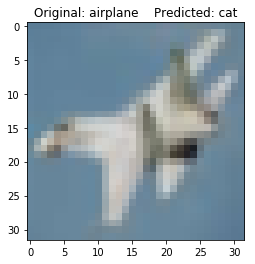

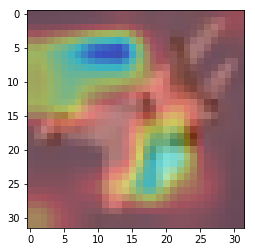

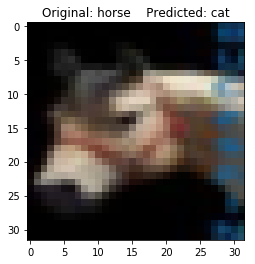

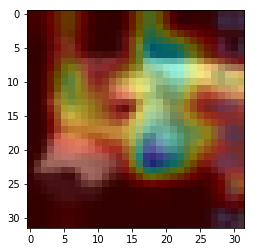

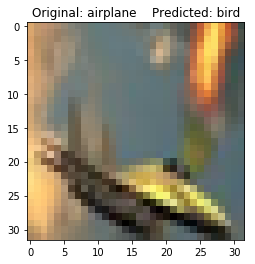

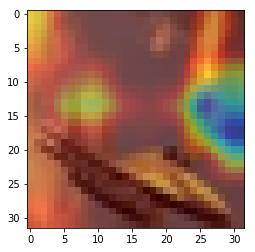

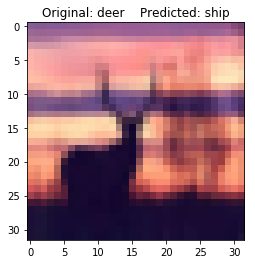

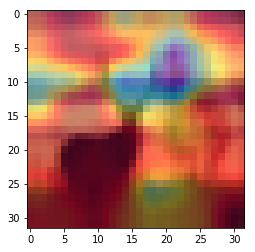

In [0]:
# Running a loop to plot original and GradCAM image for all the selected images
for i in range(len(images)):  
    grad_cam_plot(images[i])

# Part 2 of the Assignment

## Function to execute CutOut




In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# Model Architecture


In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
filepath="drive/My Drive/EVA/Assignment 9/saved_models/model_with_cutout.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callback_list = [lr_reducer, model_checkpoint]

# Training the model with Cutout

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, shuffle=False,
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, shuffle=False, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 91s 234ms/step - loss: 0.3253 - acc: 0.8956 - val_loss: 0.7282 - val_acc: 0.8128

Epoch 00001: val_acc improved from -inf to 0.81280, saving model to drive/My Drive/EVA/Assignment 9/saved_models/model_with_cutout.hdf5
Epoch 2/100
390/390 [==============================] - 88s 226ms/step - loss: 0.2754 - acc: 0.9050 - val_loss: 0.7553 - val_acc: 0.8040

Epoch 00002: val_acc did not improve from 0.81280
Epoch 3/100
390/390 [==============================] - 88s 226ms/step - loss: 0.2647 - acc: 0.9077 - val_loss: 0.6455 - val_acc: 0.8300

Epoch 00003: val_acc improved from 0.81280 to 0.83000, saving model to drive/My Drive/EVA/Assignment 9/saved_models/model_with_cutout.hdf5
Epoch 4/100
390/390 [==============================] - 88s 226ms/step - loss: 0.2478 - acc: 0.9131 - val_loss: 0.6118 - val_acc: 0.8404

Epoch 00004: val_acc improved from 0.83000 to 0.84040, saving model to drive/My Drive/EVA/Assignment 9/saved_models/model_with_

# Loading the best model

In [0]:
model = load_model('drive/My Drive/EVA/Assignment 9/saved_models/model_with_cutout.hdf5')

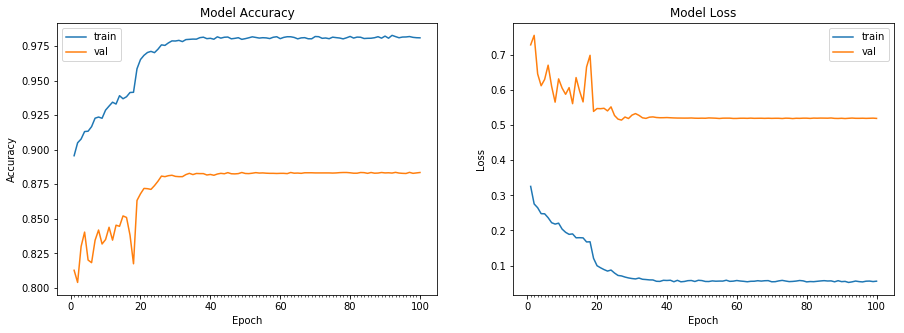

Accuracy on test data is: 88.36


In [0]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
model.evaluate(test_features, test_labels)

10000/10000 [==============================] - 4s 393us/step


[0.5198467668741942, 0.8836]

# Selecting images to perform gradCAM

In [0]:
data = {'pred': model.predict_classes(test_features), 'true': np.argmax(test_labels,axis=1)} #axis=1!important!
df_cutout = pd.DataFrame(data=data)

# shows total mispredictions
misclassified_output_with_cutout = df_cutout[(df_cutout.pred != df_cutout.true)]
classified_output_with_cutout = df_cutout[(df_cutout.pred == df_cutout.true)]

misclassified_output_with_cutout.shape

(1164, 2)

In [0]:
images = [24,44,140,222]

### Considering the layer: conv2d_8

In [0]:
#Function to plot original image and GradCAM image
def grad_cam_plot(image_number):
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    # Pixel normalization for test images
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    test_labels = np_utils.to_categorical(test_labels, num_classes)

    img = test_features[image_number]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    img = test_features[image_number]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.title("Original: " + getClassName(test_labels[image_number])+"    Predicted: " + getClassName(class_idx))
    plt.imshow(img)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
    cv2.waitKey(0)

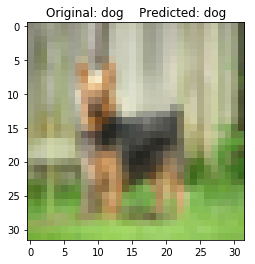

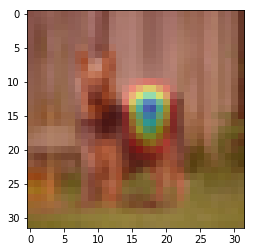

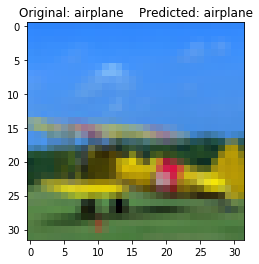

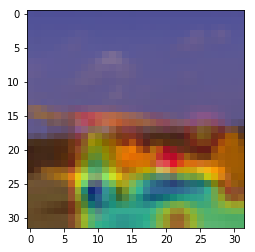

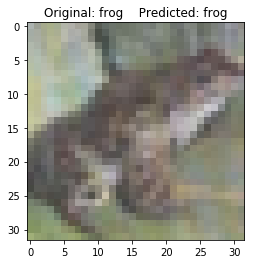

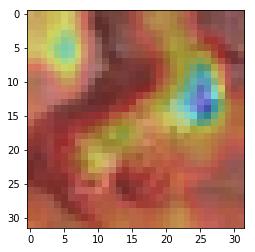

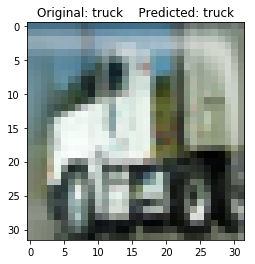

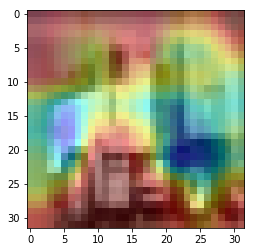

In [0]:
# Running a loop to plot original and GradCAM image for all the selected images
for i in range(len(images)):  
    grad_cam_plot(images[i])

### Considering the layer: activation_8

In [0]:
#Function to plot original image and GradCAM image
def grad_cam_plot(image_number):
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    # Pixel normalization for test images
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    test_labels = np_utils.to_categorical(test_labels, num_classes)

    img = test_features[image_number]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("activation_8")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

    img = test_features[image_number]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    plt.title("Original: " + getClassName(test_labels[image_number])+"    Predicted: " + getClassName(class_idx))
    plt.imshow(img)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
    cv2.waitKey(0)

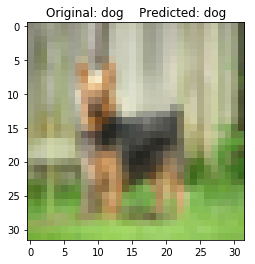

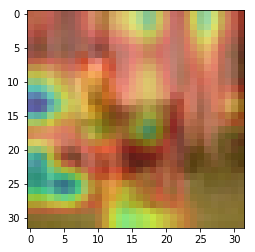

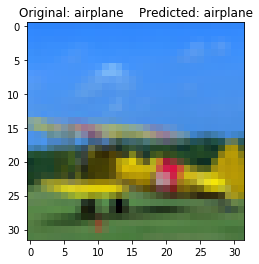

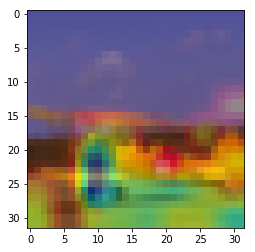

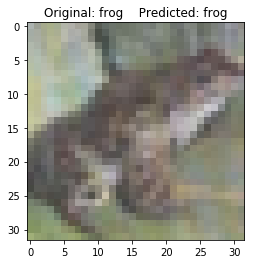

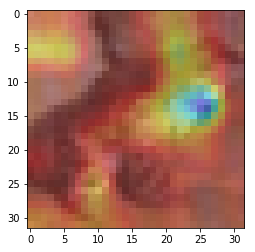

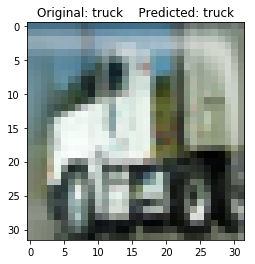

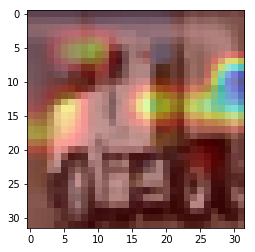

In [0]:
# Running a loop to plot original and GradCAM image for all the selected images
for i in range(len(images)):  
    grad_cam_plot(images[i])